<a href="https://colab.research.google.com/github/Jackson00Han/Time-Series-Training/blob/main/univariate%20time%20series%20without%20exgeneous/Monthly_International_Airline_Passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.SARIMA**

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib

## Pre-processing Data

In [2]:
df = pd.read_csv('monthly-airline-passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


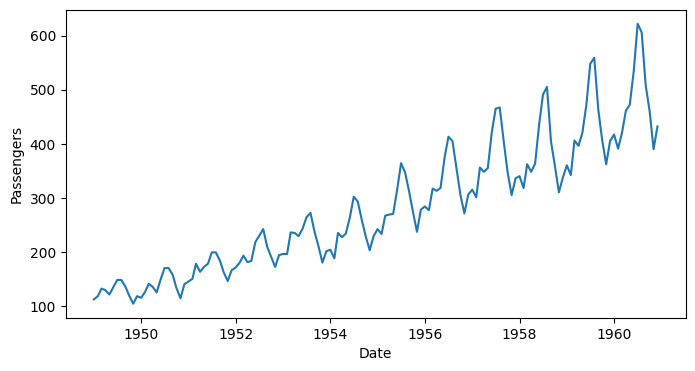

In [4]:
fig, ax= plt.subplots(figsize=(8, 4))
ax.plot(df)
ax.set_ylabel('Passengers')
ax.set_xlabel('Date')
plt.show()

Since the seasonality is multiplicative, we take a log transformation before using SARIMA model.

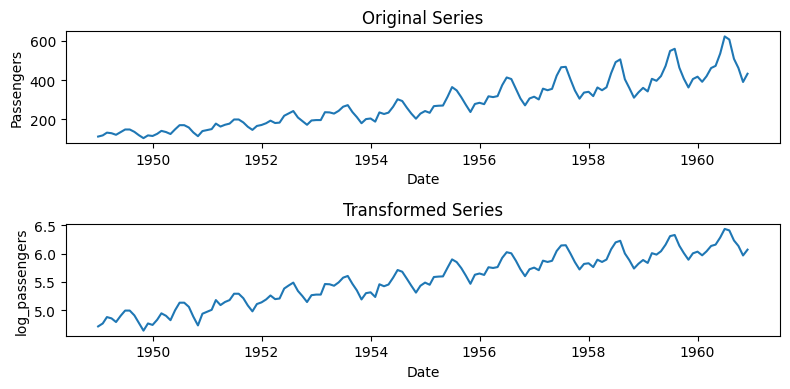

In [5]:
df['log_passengers'] = np.log(df['Passengers'])

df_log = df['log_passengers'].copy()

fig, axs = plt.subplots(2,1, figsize=(8, 4))
axs[0].plot(df['Passengers'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Passengers')
axs[0].set_title('Original Series')

axs[1].plot(df_log)
axs[1].set_xlabel('Date')
axs[1].set_ylabel('log_passengers')
axs[1].set_title('Transformed Series')

plt.tight_layout()
plt.show()

## Choosing SARIMA Order

### Manually order selecting

1st non-seasonal differencing and 1st seasonal differencing

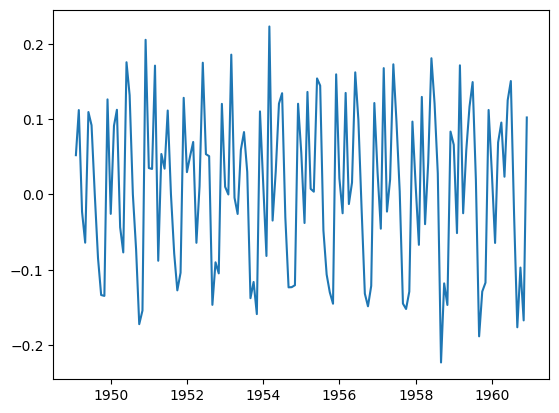

In [6]:
df_log_diff_1 = df_log.diff(1).dropna()

plt.plot(df_log_diff_1)
plt.show()

The curve above has clear seasonality

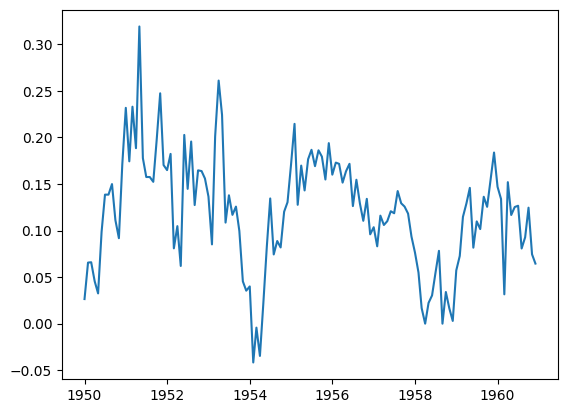

In [7]:
df_log_diff_2 = df_log.diff(12).dropna()

plt.plot(df_log_diff_2)
plt.show()

The curve above has a clear dynamic variance

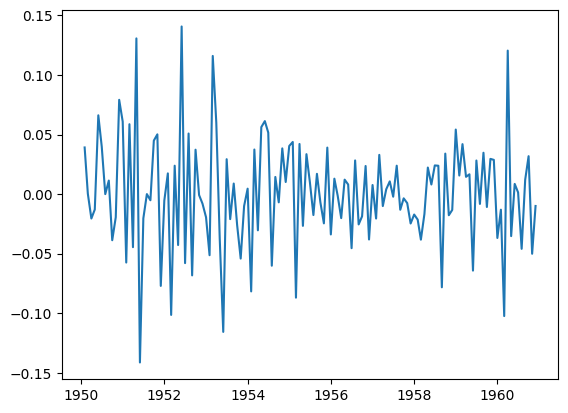

In [8]:
df_log_diff_3 = df_log.diff(1).diff(12).dropna()

plt.plot(df_log_diff_3)
plt.show()

As we expect, the curve above appears relatively stable. We use this for further training.

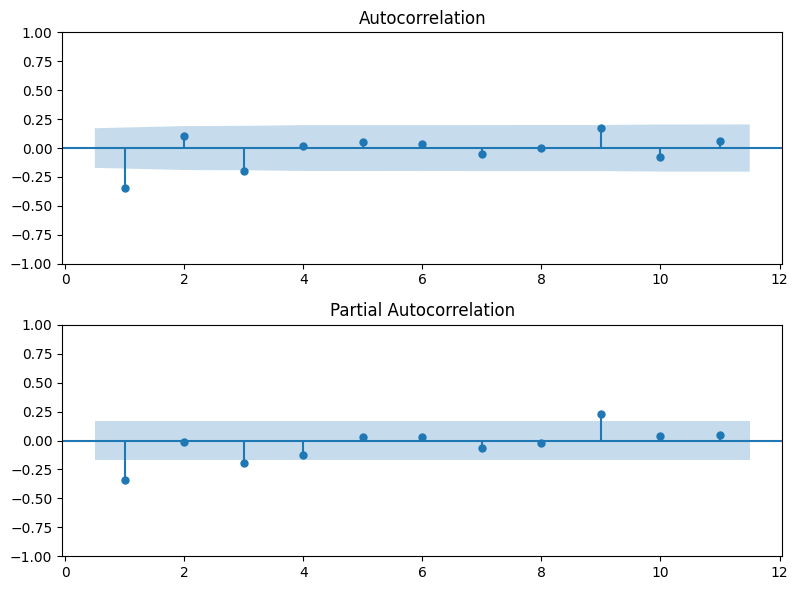

In [9]:
df_log_diff = df_log_diff_3

# ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6))

plot_acf(df_log_diff, ax=ax1, zero=False, lags=11)
plot_pacf(df_log_diff, ax=ax2, zero=False, lags=11)

plt.tight_layout()
plt.show()

ACF cuts off at lag 1, PACF cuts off at lag 1 as well with a weeker sign. In face, both figs have no strong signs. One may try (p,q)= (1,1), or (0,1)

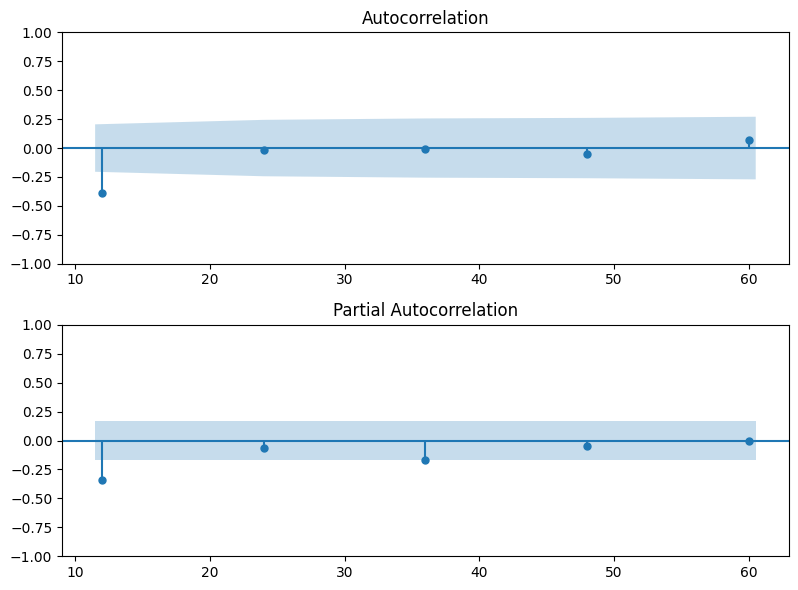

In [10]:
lags = [12, 24, 36, 48, 60]

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6))

plot_acf(df_log_diff, ax=ax1, zero=False, lags=lags)
plot_pacf(df_log_diff, ax=ax2, zero=False, lags=lags)

plt.tight_layout()
plt.show()

ACF cuts off at lag 12, PACF cuts off at lag 12 with a weeker sign.One may try (P,Q) = (1,1), or (0,1). Then select one based on AIC or BIC.

Overall, one may try the following orders:

Order (1,1,1) (1,1,1)_12

Order (1,1,1) (0,1,1)_12

Order (0,1,1) (1,1,1)_12

Order (0,1,1) (0,1,1)_12

In [11]:
# Order (1,1,1) (1,1,1)_12
model = SARIMAX(df_log, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_1 = model.fit()
print(results_1.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Thu, 19 Sep 2024   AIC                           -480.304
Time:                                    17:07:37   BIC                           -465.928
Sample:                                01-01-1949   HQIC                          -474.462
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1665      0.213      0.782      0.434      -0.251       0.584
ma.L1         -0.5611      0.185   

In [12]:
# Order (1,1,1) (0,1,1)_12
model = SARIMAX(df_log, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results_2 = model.fit()
print(results_2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Thu, 19 Sep 2024   AIC                           -481.893
Time:                                    17:07:44   BIC                           -470.392
Sample:                                01-01-1949   HQIC                          -477.220
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1965      0.199      0.987      0.323      -0.194       0.587
ma.L1         -0.5788      0.171   

In [13]:
# Order (0,1,1) (1,1,1)_12
model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results_3 = model.fit()
print(results_3.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 244.953
Date:                            Thu, 19 Sep 2024   AIC                           -481.906
Time:                                    17:07:54   BIC                           -470.405
Sample:                                01-01-1949   HQIC                          -477.233
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4143      0.074     -5.633      0.000      -0.558      -0.270
ar.S.L12      -0.1105      0.185   

In [14]:
# Order (0,1,1) (0,1,1)_12
model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
results_4 = model.fit()
print(results_4.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     log_passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Thu, 19 Sep 2024   AIC                           -483.393
Time:                                    17:08:00   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.502      0.000      -0.545      -0.259
ma.S.L12      -0.5569      0.096   

In [15]:
# Check out the aic values of these models
for i in range(1, 5):
    aic = eval(f"results_{i}.aic")
    print(aic)

-480.3037233777798
-481.8929842475537
-481.90623625869284
-483.39297335045745


In terms of AIC, it seems like Order (0,1,1) (0,1,1)_12 performs best among these 4 models.



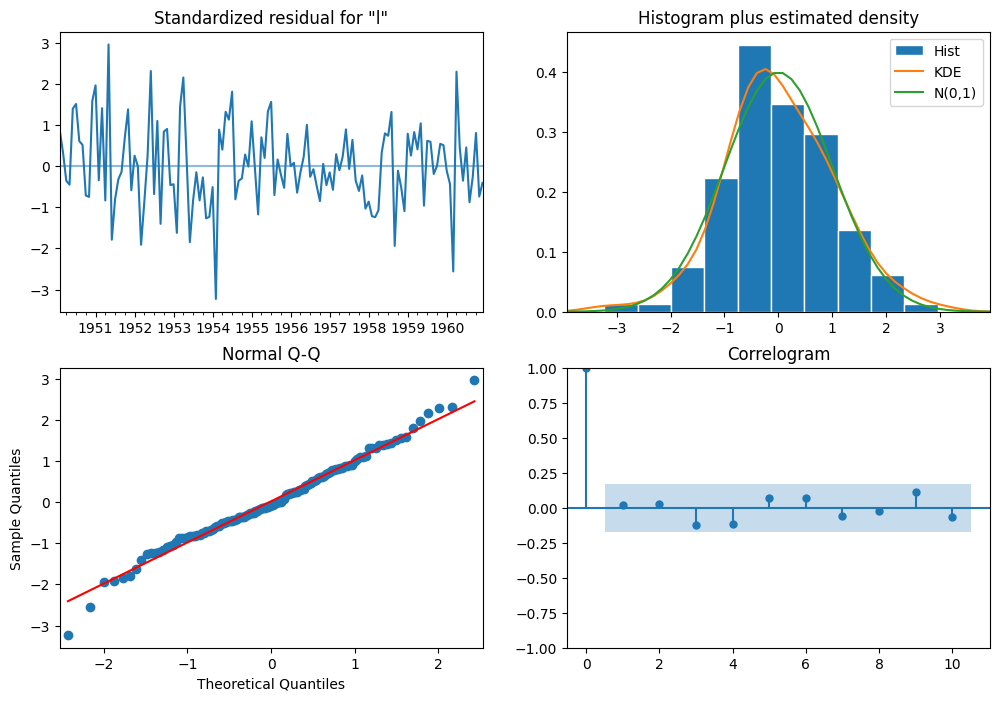

In [16]:
# Diagnostic

results_4.plot_diagnostics(figsize=(12, 8))
plt.show()

### Automated order selection

In [17]:
pip install pmdarima

In [18]:
import pmdarima as pm

model = pm.auto_arima(df_log, seasonal=True, m=12,
                      d=1, D=1,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True
                      )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-477.718, Time=9.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=1.68 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=5.62 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.91 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=4.40 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=5.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=4.04 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.901, Time=5.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=1.26 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=1.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.76 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=1.16 sec
 ARIMA(0,1,1)(0,1,1

Great! The best model is the same as our previous selection.

## Prediction and Evaluation

In [19]:
best_model = SARIMAX(df_log, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))
results = best_model.fit()

# Generate predictions on the known dataset for evaluation
dynamic_prediction = results.get_prediction(start=-12, dynamic=True)

# Extract prediction mean
mean_prediction = dynamic_prediction.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_prediction.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.iloc[:,0]
upper_limits = confidence_intervals.iloc[:,1]


# go back to the original values
mean_prediction_original_scale = np.exp(mean_prediction)
lower_limits_original_scale = np.exp(lower_limits)
upper_limits_original_scale = np.exp(upper_limits)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


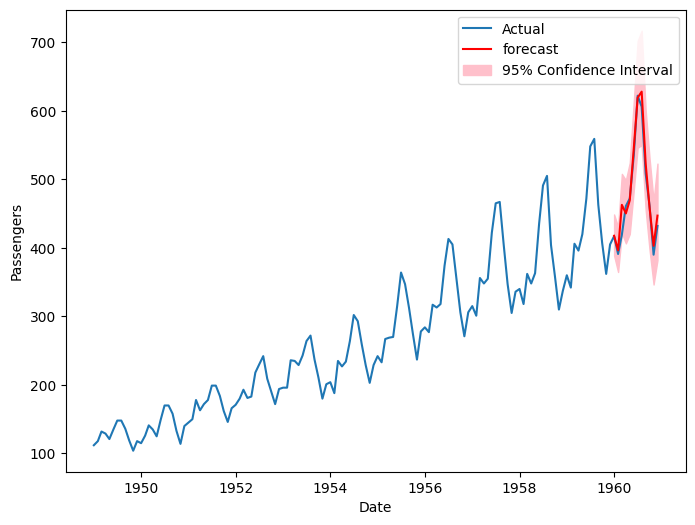

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
# plot the data
plt.plot(df.index, df['Passengers'], label='Actual')
# plot your mean forecast
plt.plot(mean_prediction.index, mean_prediction_original_scale, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits_original_scale,
         upper_limits_original_scale, color='pink', label='95% Confidence Interval')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_values = df['Passengers'][-12:]

# Compute MAE
sarima_mae = mean_absolute_error(actual_values, mean_prediction_original_scale)

# Compute MSE
sarima_mse = mean_squared_error(actual_values, mean_prediction_original_scale)

print(f'Mean Absolute Error (MAE): {sarima_mae}')
print(f'Mean Squared Error (MSE): {sarima_mse}')



Mean Absolute Error (MAE): 11.884127218761103
Mean Squared Error (MSE): 271.73363365739266


In [22]:
# Save the fitted model to a file using joblib
joblib.dump(results, 'best_sarima_model.joblib')

['best_sarima_model.joblib']

## Deploy Model and Forecast

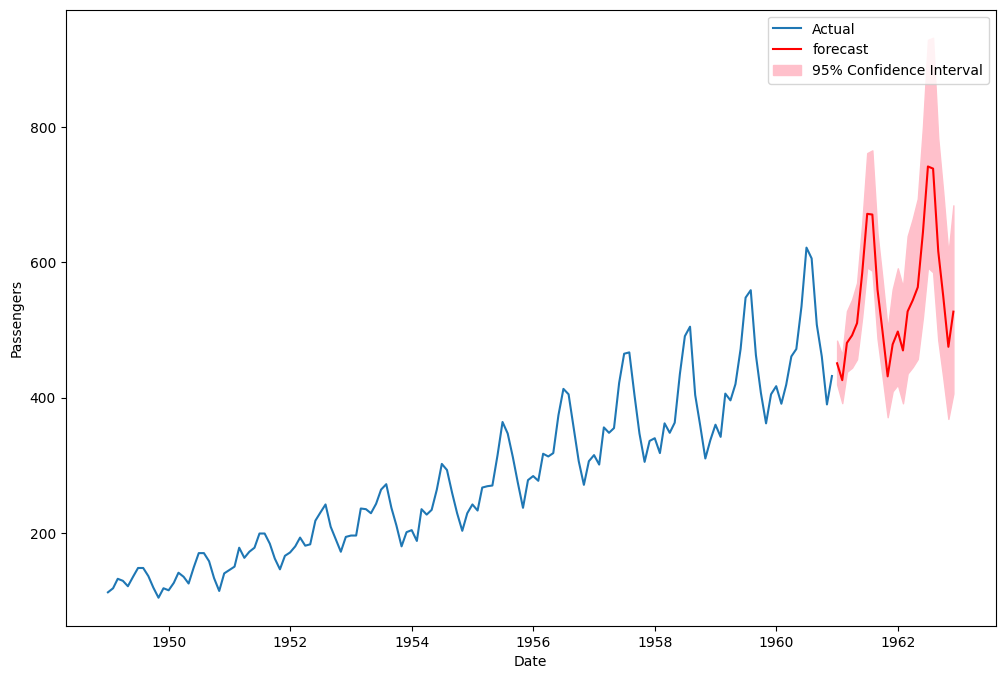

In [23]:
# Loading the model
loaded_model = joblib.load('best_sarima_model.joblib')

# Forecasting next 24 steps
forecast = loaded_model.get_forecast(steps=24)

forecast_mean = forecast.predicted_mean
forecast_mean_original_scale = np.exp(forecast_mean)


ci = forecast.conf_int()
lower_limits = ci.iloc[:,0]
upper_limits = ci.iloc[:,1]
lower_limits_original_scale = np.exp(lower_limits)
upper_limits_original_scale = np.exp(upper_limits)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.index, df['Passengers'], label='Actual')
ax.plot(forecast_mean_original_scale.index, forecast_mean_original_scale, color='r', label='forecast')
ax.fill_between(ci.index, lower_limits_original_scale, upper_limits_original_scale, color='pink', label='95% Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
ax.legend()
plt.show()

# **2. CNN_LSTM_DNN**

## Set Up

In [24]:
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from absl import logging
from sklearn.preprocessing import MinMaxScaler
import random
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
logging.set_verbosity(logging.ERROR)


def set_random_seed(seed_value=42):
    np.random.seed(seed_value)          # Set NumPy seed
    tf.random.set_seed(seed_value)      # Set TensorFlow seed
    random.seed(seed_value)             # Set Python random seed
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Ensures consistent hash values

# Call this function at the start of the project
set_random_seed()

## Pre-processing Data

In [25]:
passengers = 'monthly-airline-passengers.csv'
df = pd.read_csv(passengers)
df.set_index('Month', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

period_index = df.index.to_period('M')
diffs = period_index.to_series().astype(int).diff().dropna()

# Check if the data has continuous sequences

irregularities = diffs[diffs != 1]
if irregularities.empty:
    print("No irregularities found.")
else:
    print("Irregularities found at:")
    print(irregularities)

df.head()

No irregularities found.


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


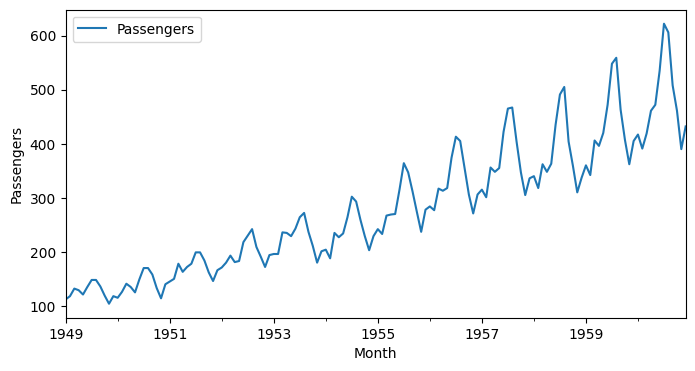

In [27]:
# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
df.plot(ax=ax)
ax.set_ylabel('Passengers')
plt.show()

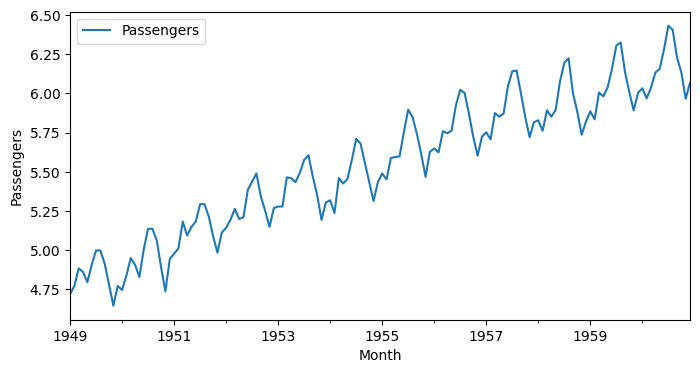

In [28]:
# Log transformation
df_log = np.log(df)

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
df_log.plot(ax=ax)
ax.set_ylabel('Passengers')
plt.show()

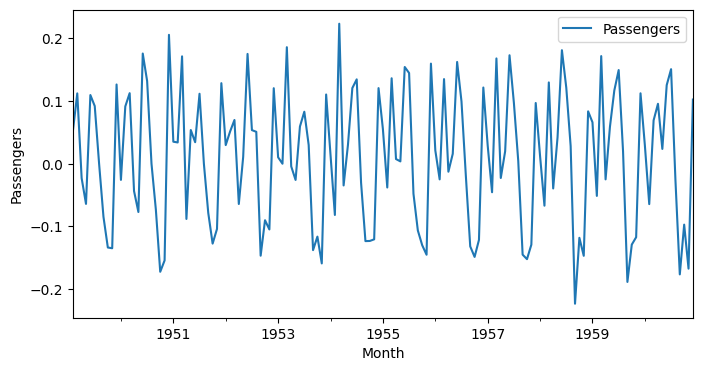

In [29]:
# diff
df_log_diff = df_log.diff().dropna()

# Visualization
fig, ax = plt.subplots(figsize=(8, 4))
df_log_diff.plot(ax=ax)
ax.set_ylabel('Passengers')
plt.show()

In [30]:
# Set the global variables
data = df_log_diff.values.reshape(-1,1)

class G:
    TIME = df_log_diff.index
    SERIES = data
    SPLIT_TIME = 12*11 # Since the seasonality period is 12, we choose 12*10 as the split time here
    WINDOW_SIZE = 12*3 # Since the seasonality period is 12, we choose 12*2 as the window size here
    BATCH_SIZE = 32
    FORECAST_SIZE = 12

    SHUFFLE_BUFFER_SIZE = 200

## Feature Engineering

In [31]:
def train_val_split(series, split_time):
    series_train = series[:split_time]
    series_val = series[split_time:]
    return series_train, series_val

series_train, series_val = train_val_split(G.SERIES, G.SPLIT_TIME)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

train_set = windowed_dataset(series = series_train,
                             window_size = G.WINDOW_SIZE,
                             batch_size = G.BATCH_SIZE,
                             shuffle_buffer = G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [32]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=4,
                               strides=1, padding="causal",
                               activation="relu",
                               input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1),

    ])

    return model

def adjust_learning_rate(dataset):

  model = create_uncompiled_model()

  lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch / 40))

  optimizer = tf.keras.optimizers.Adam()
  model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])

  history = model.fit(dataset, epochs = 200, callbacks = [lr_schedule])

  return history

# Tune the learning rate during training
lr_history = adjust_learning_rate(train_set)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0059 - mae: 0.0923 - learning_rate: 1.0000e-05
Epoch 2/200


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0055 - mae: 0.0872 - learning_rate: 1.0593e-05
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0061 - mae: 0.0936 - learning_rate: 1.1220e-05
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0059 - mae: 0.0929 - learning_rate: 1.1885e-05
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0058 - mae: 0.0903 - learning_rate: 1.2589e-05
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0058 - mae: 0.0890 - learning_rate: 1.3335e-05
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0056 - mae: 0.0885 - learning_rate: 1.4125e-05
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0055 - mae: 0.0886 - learning_rate: 1.4962e-05
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0053 - mae: 0.0851 - learning_rate: 1.5849e-05
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0055 - mae: 0.0867 - learning_rate: 1.6788e-05
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/st

(1e-05, 1.0, 0.0, 0.01)

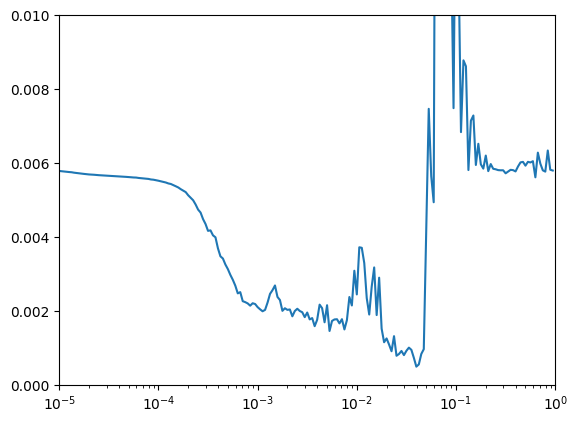

In [33]:
plt.semilogx(lr_history.history['learning_rate'], lr_history.history['loss'])
plt.axis([1e-5, 1 , 0, 0.01])

It turns out that the model performs more stable and better when the learning rate is around 1e-4.

## Compiling the model

In [34]:
def create_model():

  model = create_uncompiled_model()

  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=['mae'])

  return model

model = create_model()


history = model.fit(train_set, epochs=100) # We can also add a validation set here to monitor the training process

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0059 - mae: 0.0921
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0056 - mae: 0.0899
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0053 - mae: 0.0860
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0056 - mae: 0.0890
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0053 - mae: 0.0863
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0057 - mae: 0.0896
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0054 - mae: 0.0865
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0052 - mae: 0.0865
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0050 - mae: 0.0855
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0047 - mae: 0.0820
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0046 - mae: 0.0815
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0041 - mae: 0.0788
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste

In [35]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(G.BATCH_SIZE).prefetch(1)
    forecast = model.predict(ds)

    return forecast

num = len(series_val)

lstm_predict = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze() # Compute the forecast for all series
lstm_predict = lstm_predict[-num-1:-1] # slice the predict to get only the prediction for the validation set


# Convert forecast back to original values
last_known_log = (df_log.values)[-num-1] # Take the last known log value

def inverse_transform(log_series, last_known_log):
    f_log = np.cumsum(log_series) + last_known_log
    forecast_original_scale = np.exp(f_log)
    return forecast_original_scale


predict_original_scale = inverse_transform(lstm_predict, last_known_log)
actual = df['Passengers'].values[-num:]

original_mse_val = mean_squared_error(predict_original_scale, actual)
original_mae_val = mean_absolute_error(predict_original_scale, actual)

print(f'mse: {original_mse_val}')
print(f'mae: {original_mae_val}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
mse: 203.32468344015007
mae: 9.862619024945987


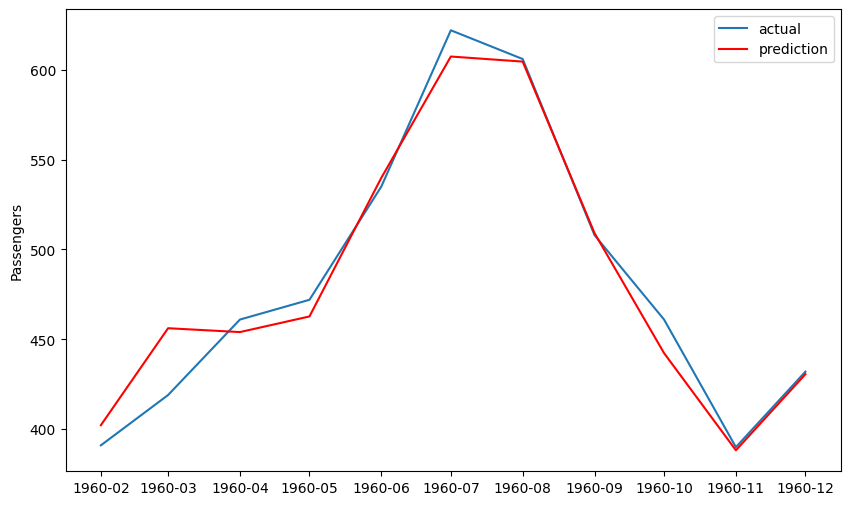

In [36]:
predict_time = G.TIME[-num:]
predictions = pd.Series(predict_original_scale, index=predict_time)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df[-num:], label='actual')
ax.plot(predictions, label='prediction', color='r')
ax.set_ylabel('Passengers')
ax.legend()

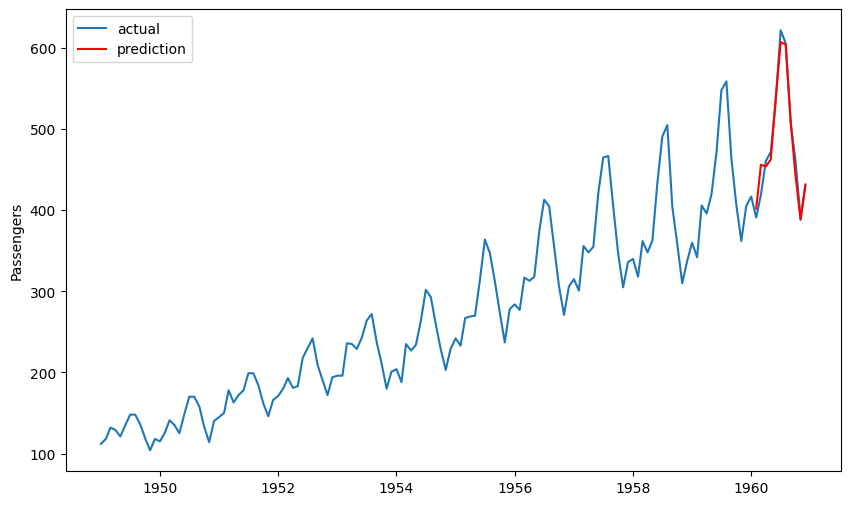

In [37]:
predict_time = G.TIME[-num:]
predictions = pd.Series(predict_original_scale, index=predict_time)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df, label='actual')
ax.plot(predictions, label='prediction', color='red')

ax.set_ylabel('Passengers')
ax.legend()

The model uses a sliding window approach to predict the next time step. It looks at a fixed-length window of past values (e.g., the last 36 months) to forecast the next value. Based on metrics such as MSE (Mean Squared Error) and MAE (Mean Absolute Error), the model performs better than SARIMA.

However, so far, we have only predicted one time step at a time based on the previous window of data. To generate multi-step forecasts (i.e., predicting several future values in sequence), we need to apply recursive forecasting. This involves feeding each predicted value back into the model to predict the subsequent values. While effective, this method can lead to error accumulation over longer forecast periods. For more details on how machine learning models handle multi-step time series forecasting, please refer to this work: [link].

## Deploy Model and Forecast

In [38]:
# To forecast the next multi-steps, we need an autoregressive forecasting algorithm

def forecast_single_rolling_window(test_window, model, window_size, forecast_size):

    buffer = test_window.values
    forecast_list = np.zeros(forecast_size)

    for i in range(forecast_size):
        input = buffer.reshape(1, window_size, 1)
        forecast = model.predict(input)[0][0]
        forecast_list[i] = forecast

        buffer[1:] = buffer[:-1]
        buffer[0] = forecast

    return forecast_list

last_rows = df_log_diff[-G.WINDOW_SIZE:]

forecast = forecast_single_rolling_window(last_rows, model, G.WINDOW_SIZE, G.FORECAST_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


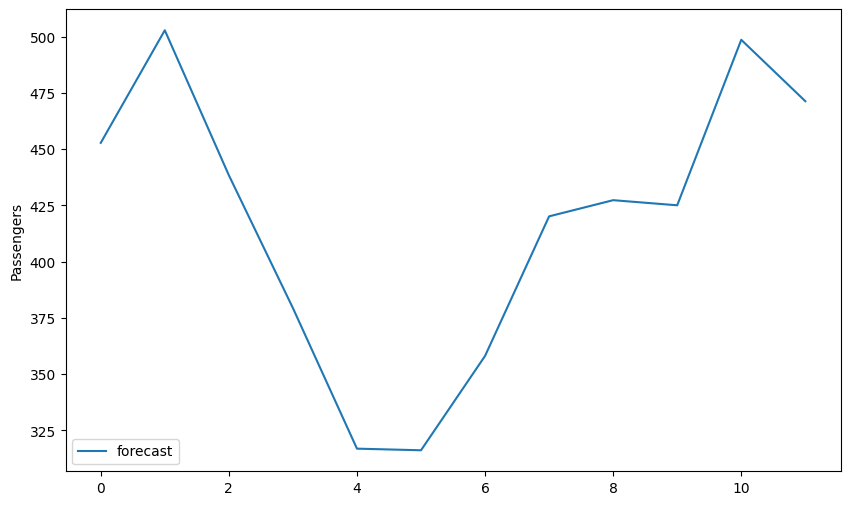

In [39]:
# Convert forecast back to original values
last_known_log = (df_log.values)[-1] # Take the last known log value

forecast_original_scale = inverse_transform(forecast, last_known_log)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(forecast_original_scale, label='forecast')
ax.set_ylabel('Passengers')
ax.legend()

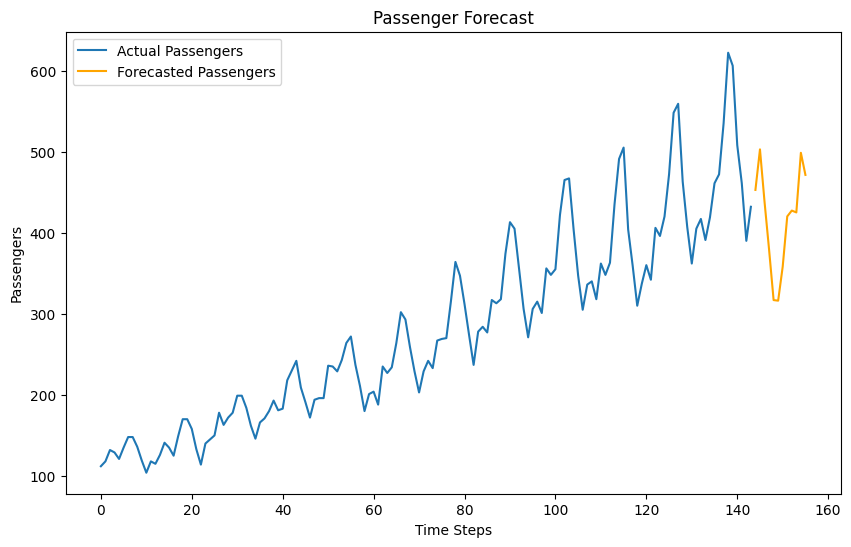

In [40]:
# Combine actual values with forecasted values for a continuous plot


actual_values = df['Passengers'].values

combined_values = np.concatenate((actual_values, forecast_original_scale))

x_values = np.arange(len(combined_values))

plt.figure(figsize=(10, 6))

plt.plot(x_values[:len(actual_values)], actual_values, label='Actual Passengers')
plt.plot(x_values[len(actual_values):], forecast_original_scale, label='Forecasted Passengers', color='orange')

plt.title("Passenger Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Passengers")
plt.legend()

plt.show()

# **2.PyCaret**

## Preparation

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. With PyCaret, you spend less time coding and more time on analysis. You can train your model, analyze it, iterate faster than ever before, and deploy it instantaneously as a REST API or even build a simple front-end ML app, all from your favorite Notebook.

In [41]:
pip install pycaret[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 32.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of selenium to determine which version is compatible with other requirements. This 

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.datasets import get_data
#from pycaret.time_series import TSForecastingExperiment
from pycaret.time_series import *

#from dataclasses import dataclass

In [2]:
data = get_data('monthly-airline-passengers', verbose=False)

data['Month'] = pd.to_datetime(data['Month'])

data.set_index('Month', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [3]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


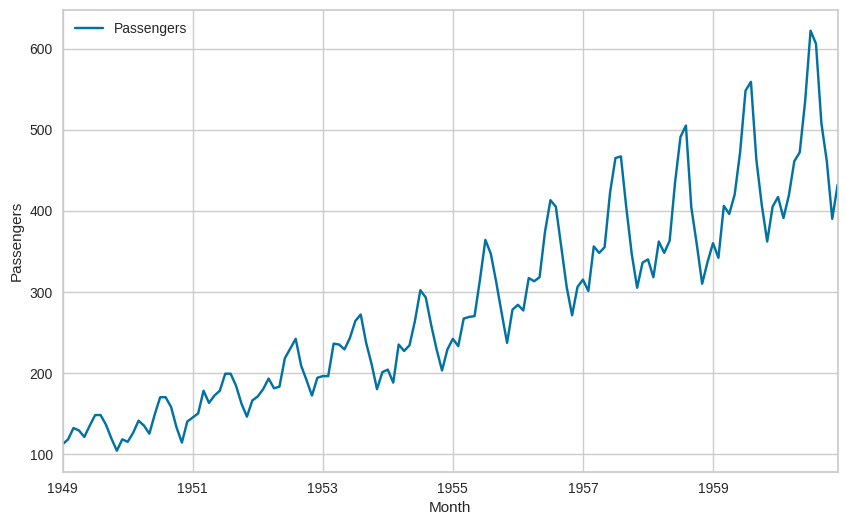

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax)
ax.set_ylabel('Passengers')

plt.show()

In [5]:
# Parameters

fh=12

# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

## Initialization

In [6]:
s = setup(data, target='Passengers', fh = fh, fold=3, session_id=31, fig_kwargs=fig_kwargs)

,Description,Value
0,session_id,31
1,Target,Passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [7]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,144.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,280.298611
3,Summary,Statistics,Transformed,Median,,265.5
4,Summary,Statistics,Transformed,Standard Deviation,,119.966317
5,Summary,Statistics,Transformed,Variance,,14391.917201
6,Summary,Statistics,Transformed,Kurtosis,,-0.364942
7,Summary,Statistics,Transformed,Skewness,,0.58316
8,Summary,Statistics,Transformed,# Distinct Values,,118.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",1606.083817


## Compare Models

In [8]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.5852,0.6105,17.1926,20.1633,0.0435,0.0439,0.8918,0.1367
ets,ETS,0.5931,0.6212,17.4165,20.5102,0.0440,0.0445,0.8882,0.2133
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6482,0.7089,19.1419,23.4703,0.0477,0.0475,0.8528,0.8600
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6813,0.7866,20.0334,25.9670,0.0491,0.0499,0.8113,1.0133
arima,ARIMA,0.6830,0.6735,20.0069,22.2199,0.0501,0.0507,0.8677,0.5400
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7004,0.7702,20.6084,25.4401,0.0509,0.0514,0.8215,0.8000
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7004,0.7703,20.6086,25.4405,0.0509,0.0514,0.8215,0.7600
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7029,0.7732,20.6816,25.5362,0.0511,0.0516,0.8201,0.7400
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7373,25.6005,0.0512,0.0517,0.8193,0.4567
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7366,25.6009,0.0512,0.0517,0.8192,0.5500


Processing:   0%|          | 0/121 [00:00<?, ?it/s]

## Prediction

In [9]:
# The predict_model function returns y_pred.
pred = predict_model(best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.3382,0.4575,10.2997,15.8074,0.0221,0.0216,0.9549


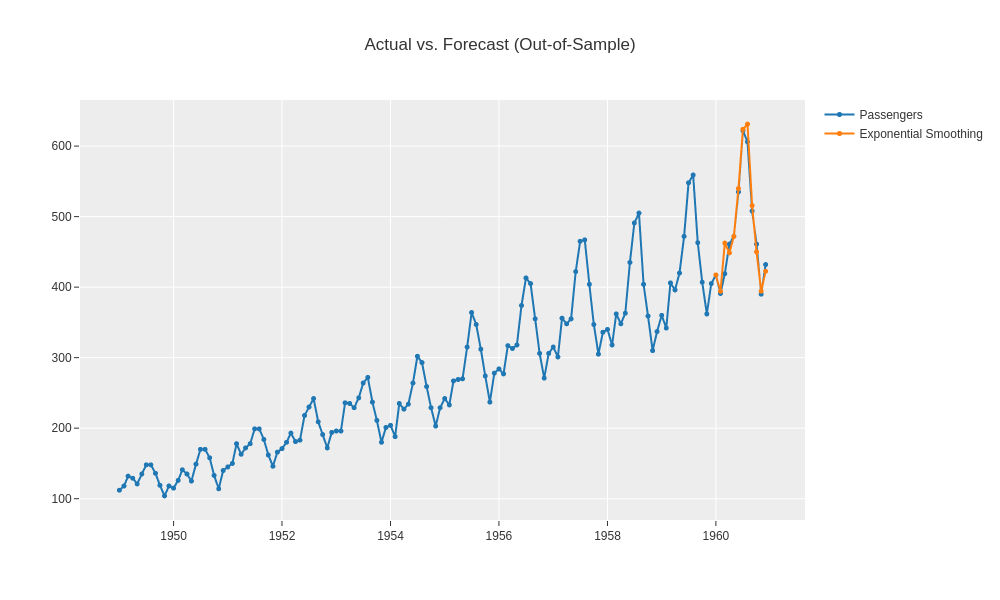

In [10]:
plot_model(best, plot = 'forecast')

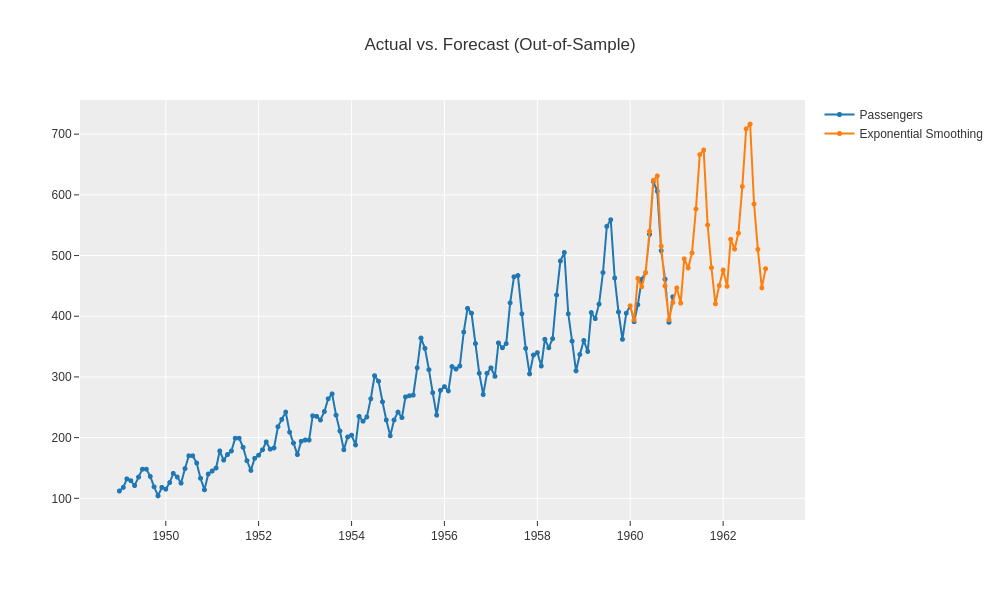

In [11]:
# If one wants to predict the future 36 months

pred_future = predict_model(best, fh=36)

plot_model(best, plot = 'forecast', data_kwargs = {'fh': 36})

## Save and deploy models

In [12]:
# Finalize model
final_best = finalize_model(best)

# Save model
save_model(final_best, 'my_final_best_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ExponentialSmoothing(seasonal='mul',
                                                                                                                                                      sp=12,
                                                                                                                                                      trend='add'))]))]))]))]),
 'my_final_best_model.pkl')

In [13]:
# When you already saved the best model

# Load data
data = get_data('monthly-airline-passengers', verbose=False)
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Initialize the PyCaret environment
setup(data, target='Passengers')

# Load the Model
loaded_model = load_model('my_final_best_model')

# 3. Predict future values
pred_future_pro = predict_model(loaded_model, fh=36)

# 4. Plot the forecast
plot_model(loaded_model, plot='forecast', data_kwargs={'fh': 12})

,Description,Value
0,session_id,7510
1,Target,Passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(143, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Transformation Pipeline and Model Successfully Loaded
